In [1]:
from io import StringIO
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import subprocess as sb
%matplotlib inline

In [4]:
completed = sb.run(
    ["build/apps/src/scratch/scan", 
                    "500", "500", "150", "300", "0", "1", "0"], 
    capture_output=True,
    encoding="utf-8")
df = pd.read_csv(StringIO(completed.stdout), sep=",")
df.describe()

,qv,T,delta_n,delta_q
count,250000.000000,250000.00000,250000.0,250000.0
mean,0.499000,224.85000,0.0,0.0
std,0.288675,43.30127,0.0,0.0
min,0.000000,150.00000,0.0,0.0
25%,0.249500,187.42500,0.0,0.0
50%,0.499000,224.85000,0.0,0.0
75%,0.748500,262.27500,0.0,0.0
max,0.998000,299.70000,0.0,0.0


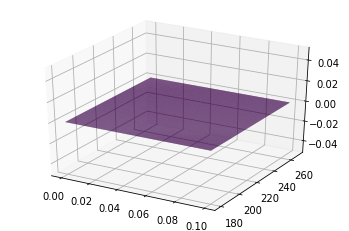

In [4]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['qv'], df['T'], df['delta_q'], cmap=plt.cm.viridis, linewidth=0.2)
plt.show()

In [5]:
surf=ax.plot_trisurf(df['qv'], df['T'], df['delta_q'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
plt.show()